**Final Project**
**My Goal: my goal is to attempt to predict total yearly attendance for teams in the NFL. This will be based on : Weekly attendance, wins, strength of schedule, point differential, playoff appearances, and Super Bowl wins.**

the first few cells are some data understanding/cleaning/pre-processing.

The later cells are dedicated to modeling and training

Note: 'home' in this context means 'home attendance'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


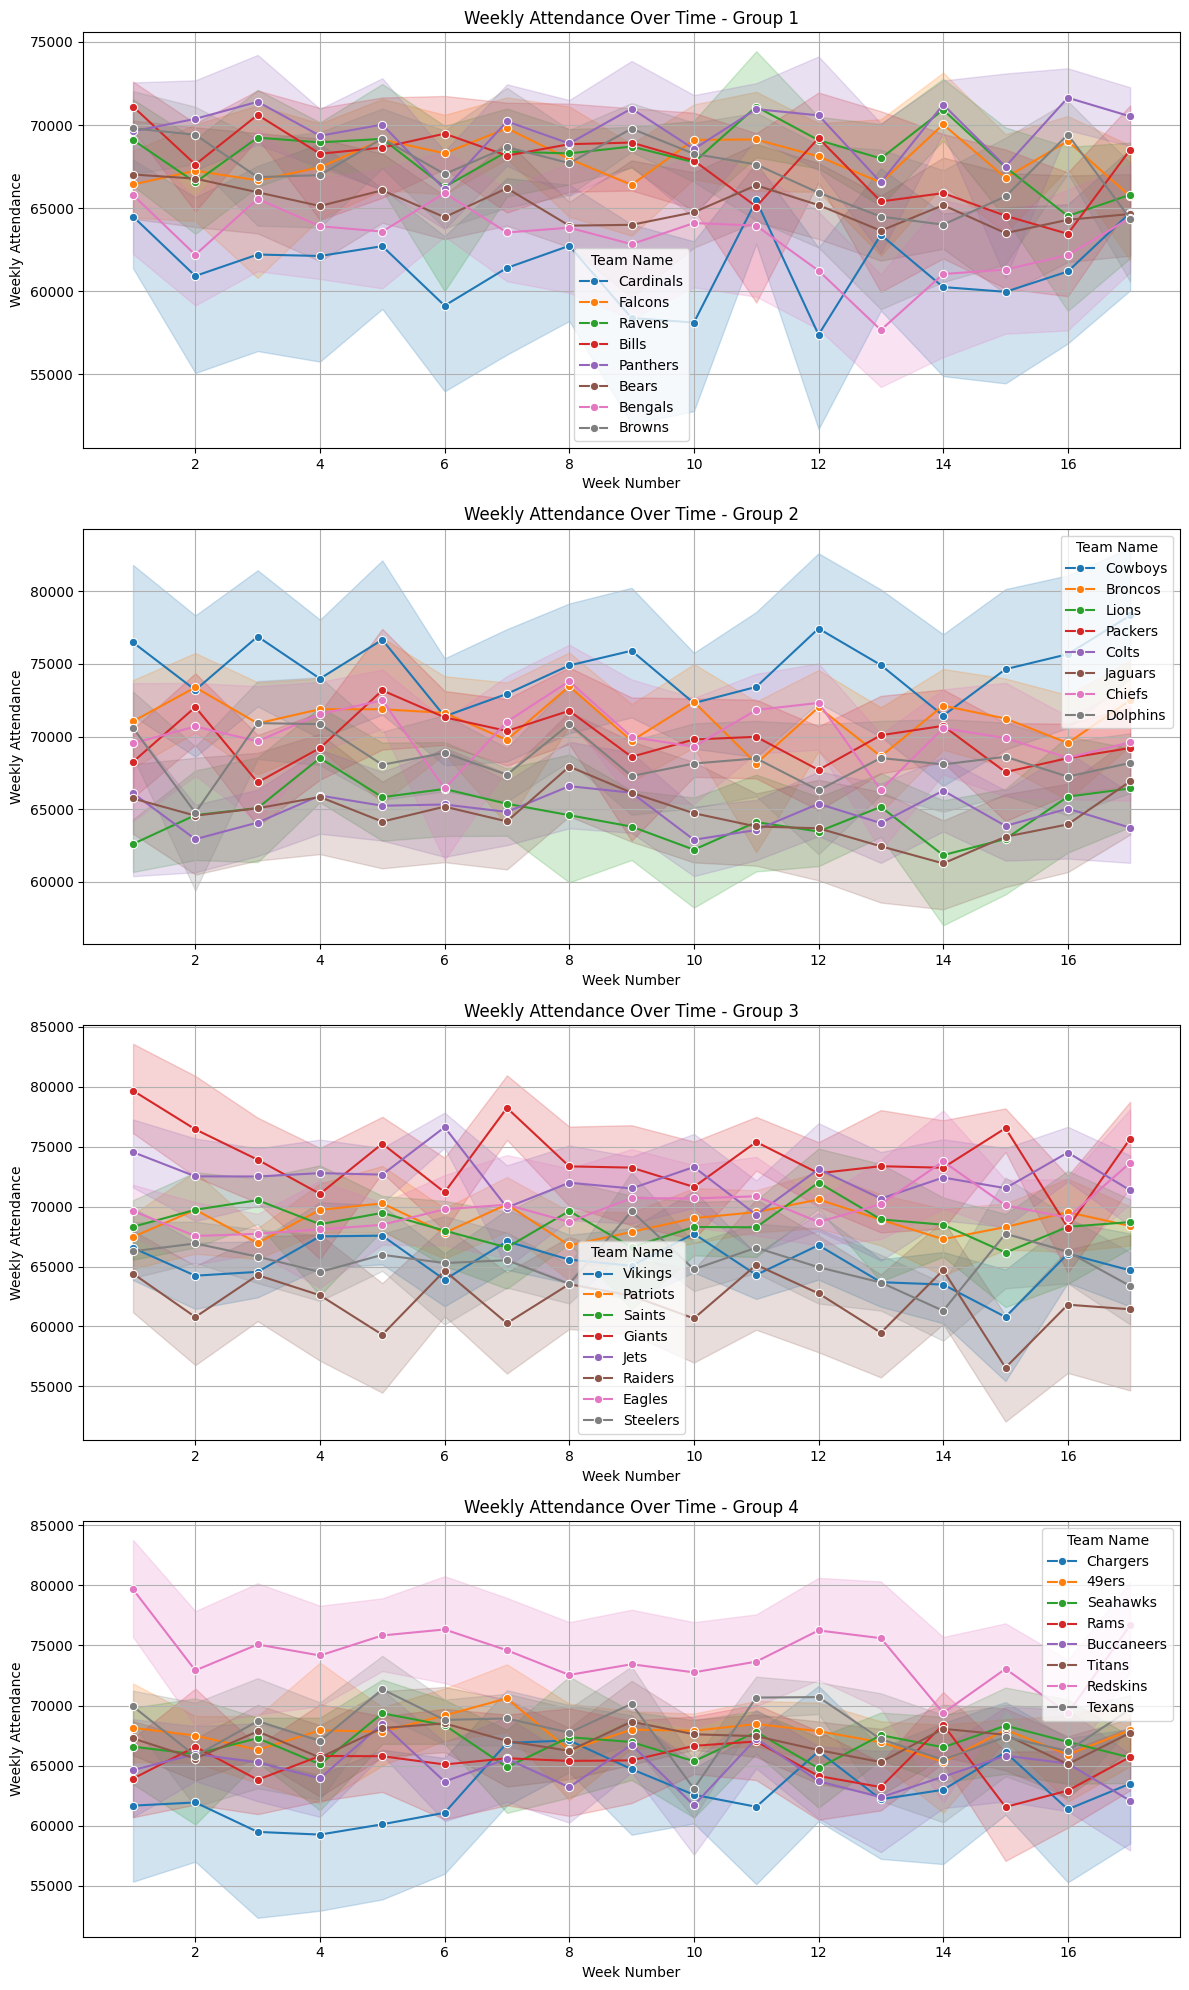

In [ ]:
## Project
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

##file_path = '/content/drive/My Drive/Colab Notebooks/attendance.csv'
##df = pd.read_csv(file_path)

##file_path = '/content/drive/My Drive/Colab Notebooks/attendance.csv'
##df_attendance = pd.read_csv(file_path)

#import data from first csv
attendance_csv = pd.read_csv("attendance.csv")
df_attendance = pd.DataFrame(attendance_csv)

df_attendance.drop(['total', 'away'], axis=1, inplace=True)
#drop unecessary/correlated columns

df_class = df_attendance.groupby(['team', 'year', 'home'], as_index=False).first()
#separate away predicted class(usuing home instead of total to attempt to make it more applicable to any 1 team)
df_class.drop(['weekly_attendance', 'week'], axis=1, inplace=True)

# Calculate the average weekly attendance for each team
team_avg = df_attendance.groupby('team_name')['weekly_attendance'].mean()

# Fill NA values in weekly_attendance with the corresponding team's average
df_attendance['weekly_attendance'] = df_attendance.apply(
    lambda row: team_avg[row['team_name']] if pd.isna(row['weekly_attendance']) else row['weekly_attendance'],
    axis=1
)

#Round new values to nearest whole number. Numbers in column are large so this should be fine
df_attendance['weekly_attendance'] = df_attendance['weekly_attendance'].round(0)



# Create subplots for each group of 8 teams
num_teams = df_attendance['team_name'].nunique()
num_plots = (num_teams + 7) // 8  # Ceiling division to calculate the number of plots needed

fig, axs = plt.subplots(num_plots, figsize=(12, 5 * num_plots))

# Plot each group of 8 teams
for i, ax in enumerate(axs):
    start_idx = i * 8
    end_idx = start_idx + 8
    teams_subset = df_attendance['team_name'].unique()[start_idx:end_idx]
    df_subset = df_attendance[df_attendance['team_name'].isin(teams_subset)]

    sns.lineplot(data=df_subset, x='week', y='weekly_attendance', hue='team_name', marker='o', ax=ax)
    ax.set_title(f'Weekly Attendance Over Time - Group {i+1}')
    ax.set_xlabel('Week Number')
    ax.set_ylabel('Weekly Attendance')
    ax.legend(title='Team Name', loc='best')
    ax.grid(True)

plt.tight_layout()
plt.show()


This is just a snapshot, but what we cn see is that. Some attendance numbers are more consitent than others. Some teams get more attendance on average than others, and that weekly attendance can range from 60k to 80k people a week.

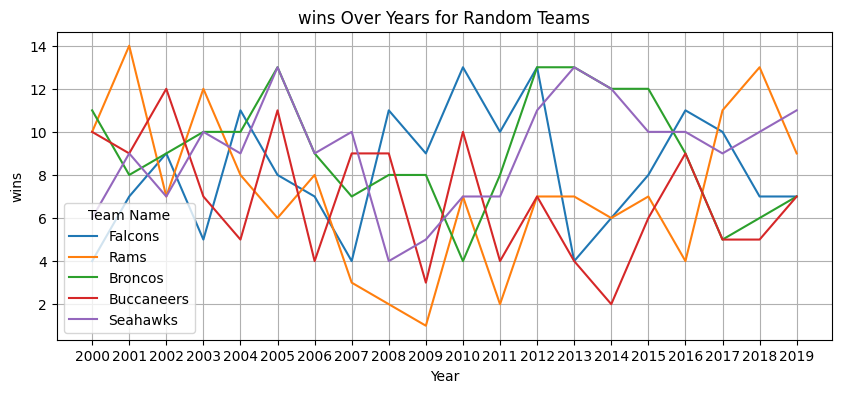

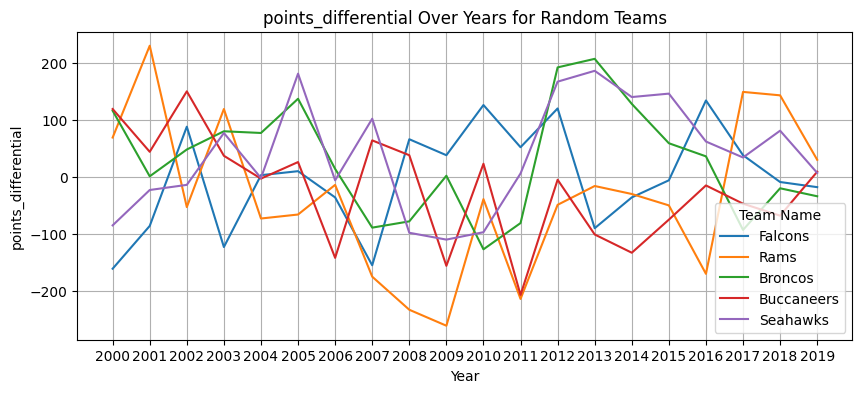

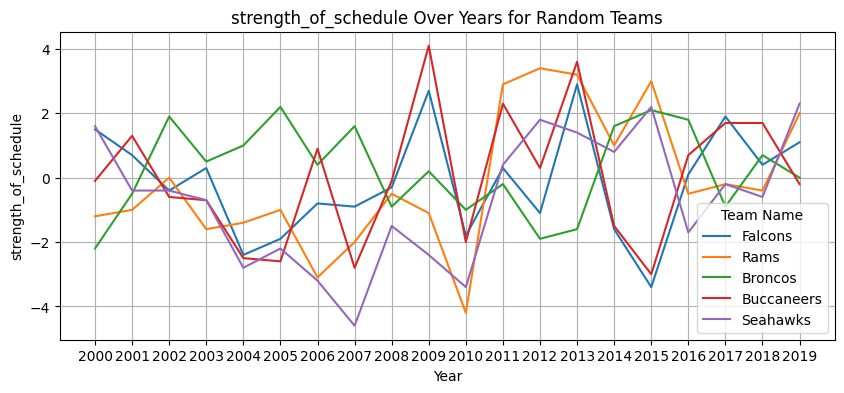

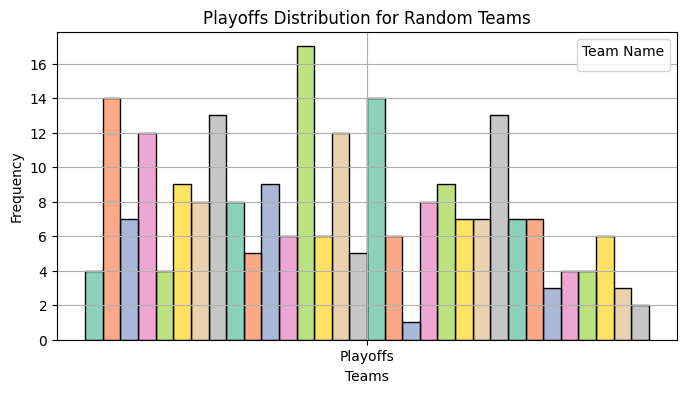

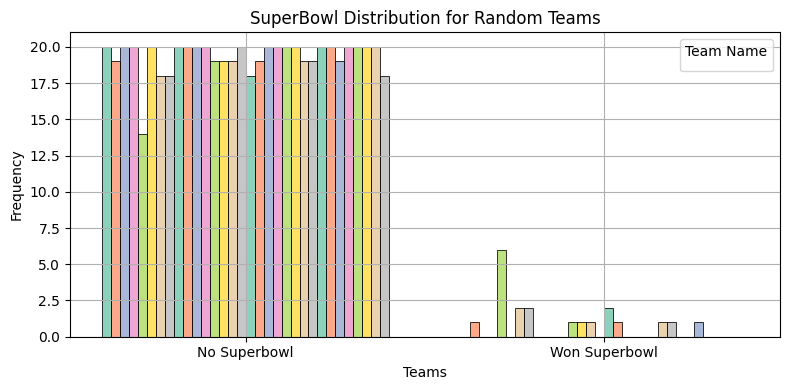

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


##file_path = '/content/drive/My Drive/Colab Notebooks/standings.csv'
##df_standings = pd.read_csv(file_path)
standings_csv = pd.read_csv("standings.csv")
df_standings = pd.DataFrame(standings_csv)

df_standings.drop(['points_for','points_against','offensive_ranking', 'defensive_ranking', 'loss'], axis=1, inplace=True)


# List of columns to plot
columns_to_plot = ['wins', 'points_differential', 'strength_of_schedule']

df_playoffs = df_standings[df_standings['playoffs'] == 'Playoffs']

# Randomly select a subset of teams
random_teams = np.random.choice(df_standings['team_name'].unique(), size=5, replace=False)  # Change size as needed

# Filter the DataFrame for the selected teams
df_subset = df_standings[df_standings['team_name'].isin(random_teams)]

df_standings.describe();


# Plot each column for the selected teams
for column in columns_to_plot:
    plt.figure(figsize=(10, 4))
    for team in random_teams:
        team_data = df_subset[df_subset['team_name'] == team]
        plt.plot(team_data['year'], team_data[column], label=team)

    plt.title(f'{column} Over Years for Random Teams')
    plt.xlabel('Year')
    plt.ylabel(column)
    plt.legend(title='Team Name', loc='best')
    plt.grid(True)
    plt.xticks(np.arange(team_data['year'].min(), team_data['year'].max()+1, 1))

# Add a subplot for the playoffs histogram

plt.figure(figsize=(8, 4))
sns.histplot(data=df_playoffs, x='playoffs', hue='team_name', multiple='dodge', shrink=0.8, palette='Set2', legend='brief')
plt.title('Playoffs Distribution for Random Teams')
plt.xlabel('Teams')
plt.ylabel('Frequency')
plt.legend(title='Team Name', loc='upper right')
plt.grid(True)

plt.figure(figsize=(8, 4))
sns.histplot(data=df_standings, x='sb_winner', hue='team_name', multiple='dodge', shrink=0.8, palette='Set2')
plt.title('SuperBowl Distribution for Random Teams')
plt.xlabel('Teams')
plt.ylabel('Frequency')
plt.legend(title='Team Name', loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

df_standings.describe();



Here we can see that there is a high variance in strength of schedule, some teams make the playoffs more consistantly than others. and very few teams get to win the super bowl. I will keep the superBowl feature since it may have an outsized impact if won on attendance.

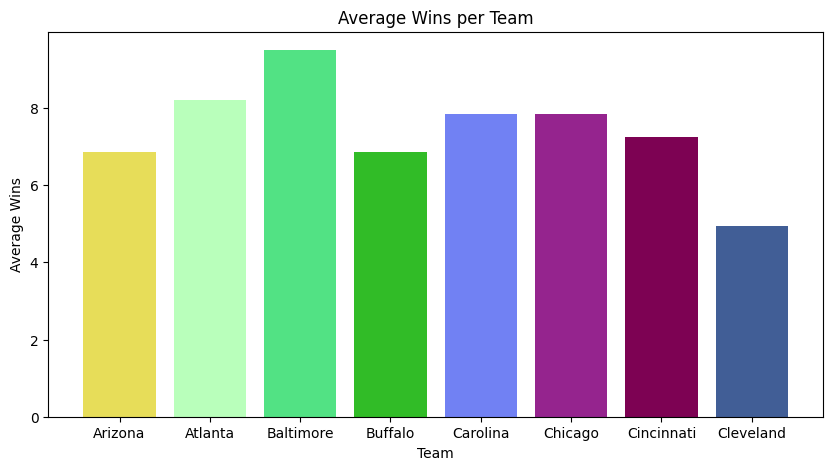

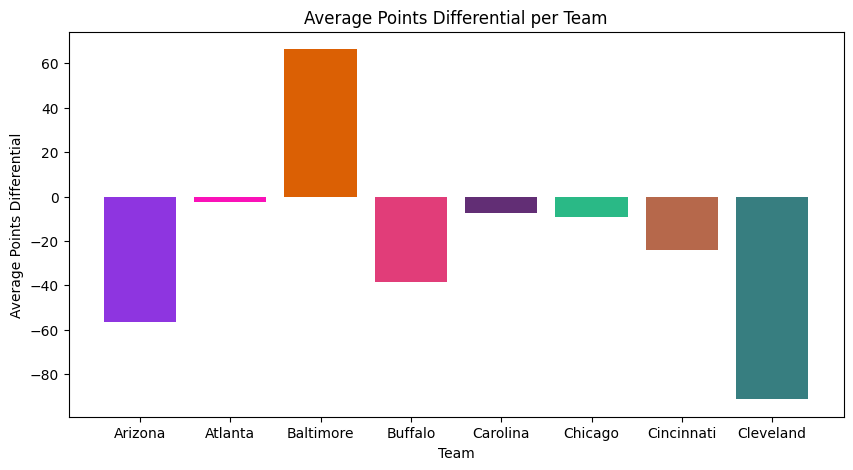

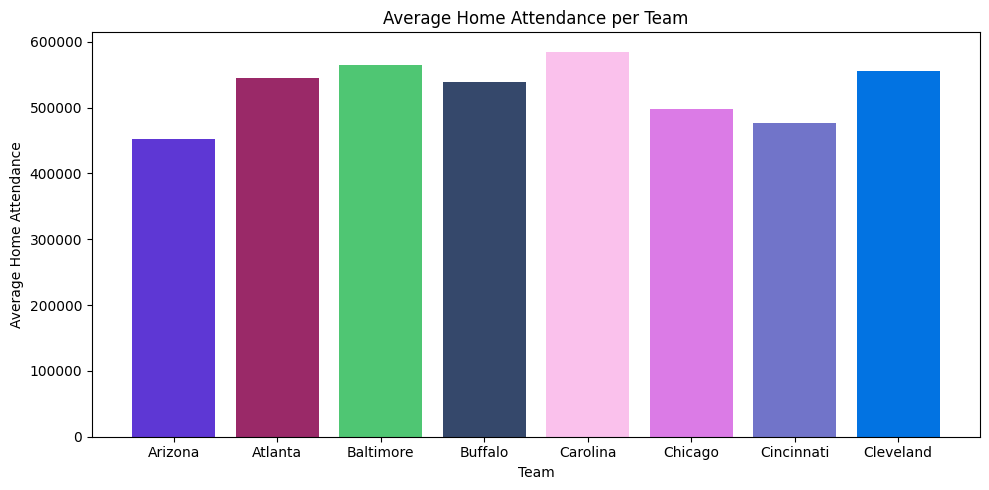

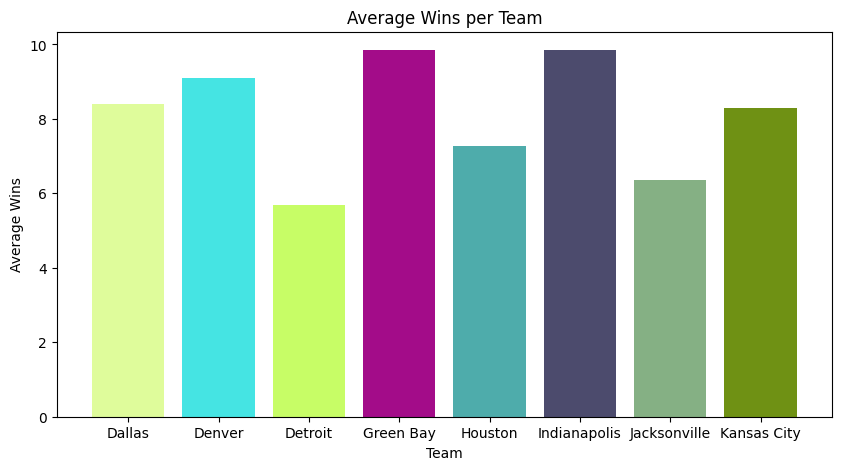

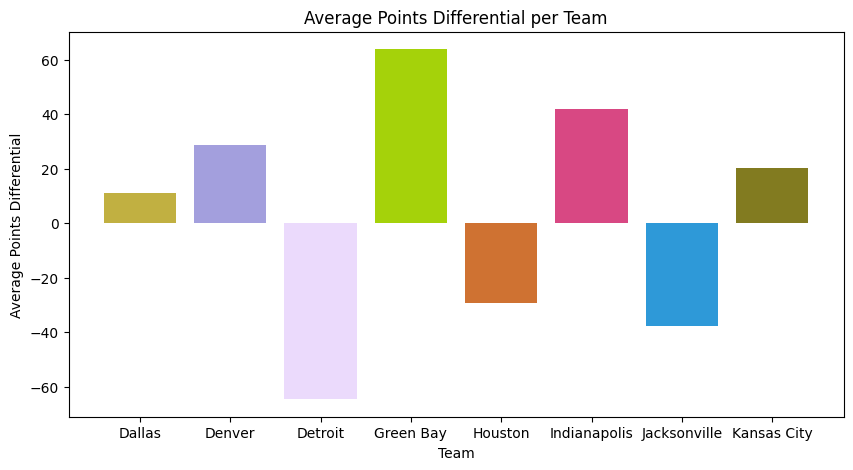

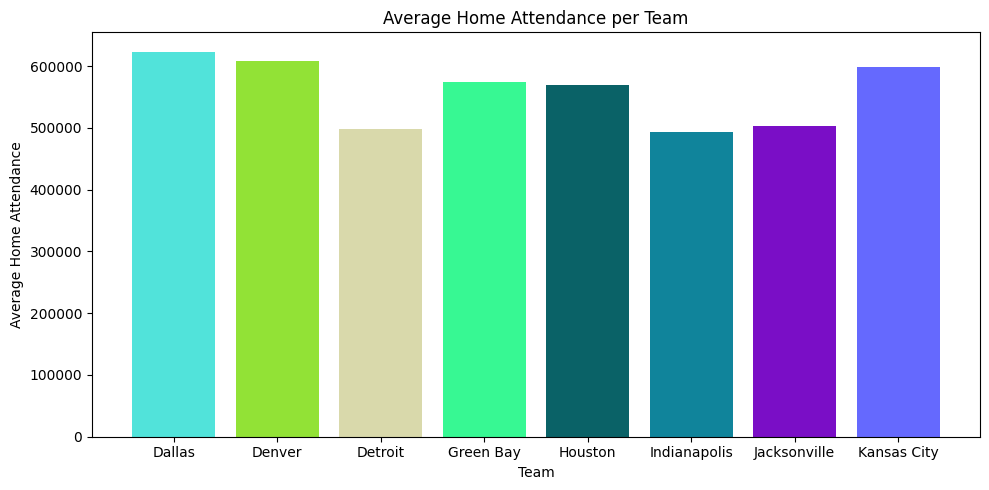

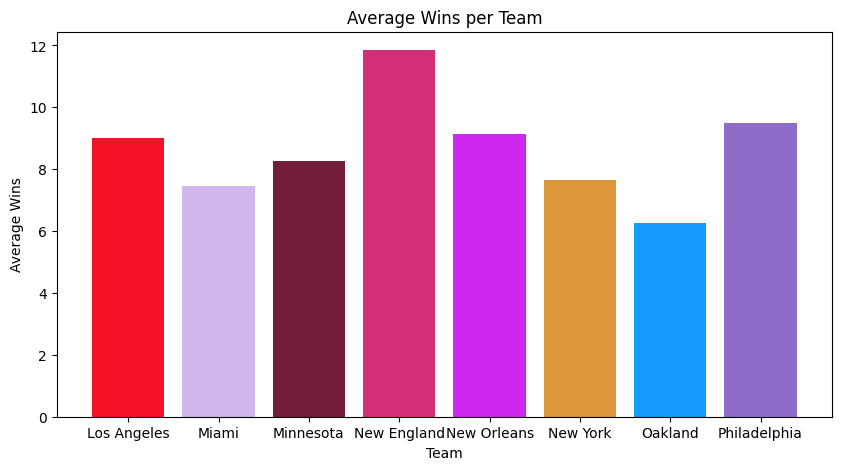

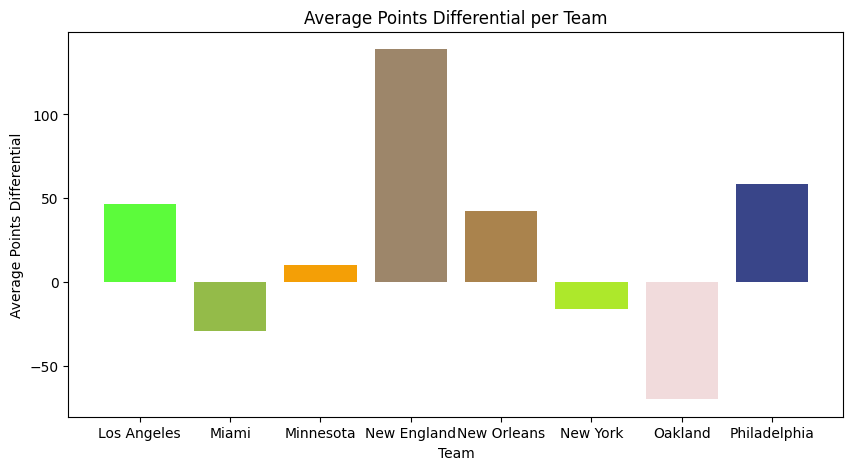

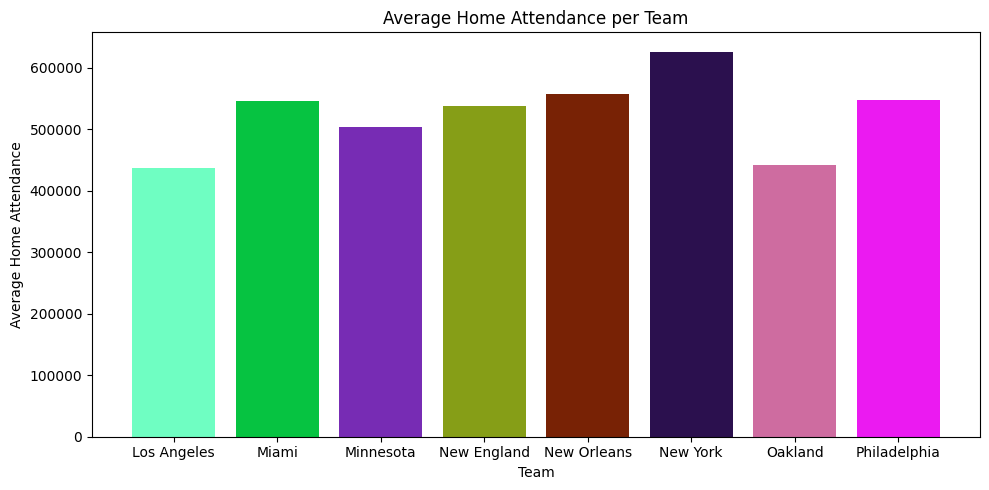

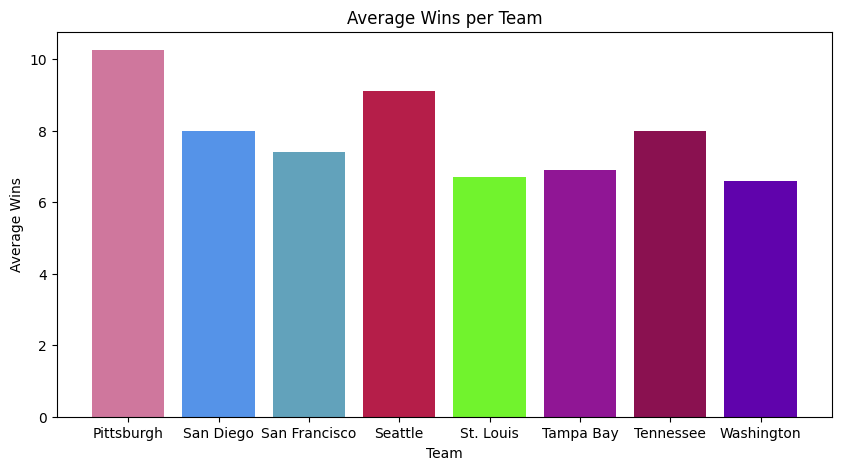

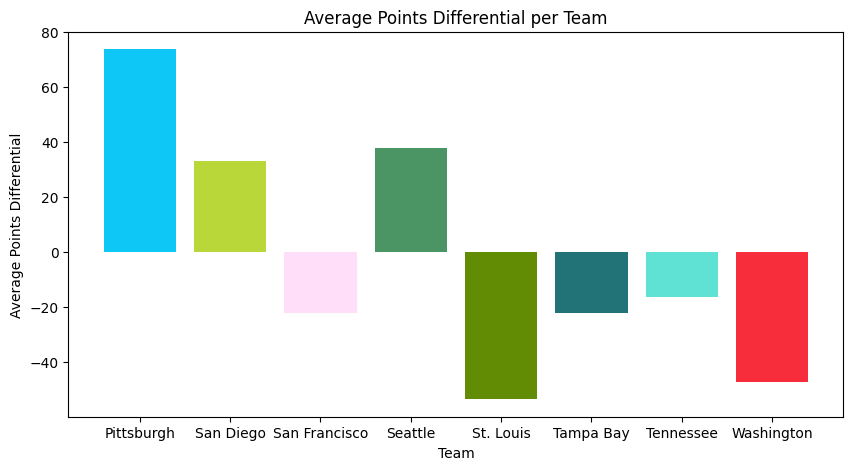

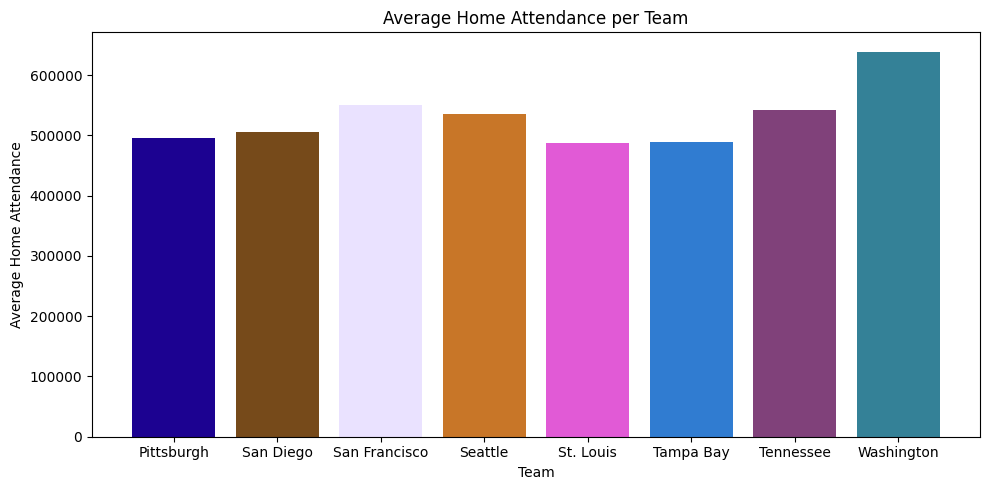

In [ ]:
import pandas as pd



# List of common columns to join on
common_columns = ['team', 'year', 'team_name']

# Merge
merged_df = df_class.merge(df_standings, on=common_columns)

# Map 'playoffs' column to 1 for 'Playoffs', 0 otherwise this is so that all the data is numerical
merged_df['playoffs'] = merged_df['playoffs'].replace({'Playoffs': 1, 'No Playoffs': 0})

# Replace 'Won SuperBowl' with 1 and anything else with 0
merged_df['sb_winner'] = merged_df['sb_winner'].replace({'Won SuperBowl': 1, 'No Superbowl': 0})

# Convert 'playoffs' and 'sb_winner' columns to numeric (float)
merged_df['playoffs'] = pd.to_numeric(merged_df['playoffs'], errors='coerce')
merged_df['sb_winner'] = pd.to_numeric(merged_df['sb_winner'], errors='coerce')

# Fill NaN values with appropriate numerical values if needed
# For example, if NaN in 'playoffs' column should be 0:
merged_df['playoffs'].fillna(0, inplace=True)
merged_df['sb_winner'].fillna(0, inplace=True)


# Display the resulting merged DataFrame
merged_df.describe()

df = merged_df

avg_stats = df.groupby('team').agg({
    'wins': 'mean',
    'points_differential': 'mean',
    'home': 'mean'
}).reset_index()

#  Define the number of teams per plot
teams_per_plot = 8

# Calculate the number of plots needed
num_plots = (len(avg_stats) + teams_per_plot - 1) // teams_per_plot

# Plotting
for i in range(num_plots):
    start_idx = i * teams_per_plot
    end_idx = (i + 1) * teams_per_plot

    # Slice the data for the current plot
    plot_data = avg_stats.iloc[start_idx:end_idx]

    # Create separate figures for each metric group
    fig_wins, axs_wins = plt.subplots(figsize=(10, 5))
    fig_diff, axs_diff = plt.subplots(figsize=(10, 5))
    fig_home, axs_home = plt.subplots(figsize=(10, 5))

    # Average wins
    axs_wins.bar(plot_data['team'], plot_data['wins'], color=np.random.rand(len(plot_data), 3))
    axs_wins.set_xlabel('Team')
    axs_wins.set_ylabel('Average Wins')
    axs_wins.set_title('Average Wins per Team')

    # Average points differential
    axs_diff.bar(plot_data['team'], plot_data['points_differential'], color=np.random.rand(len(plot_data), 3))
    axs_diff.set_xlabel('Team')
    axs_diff.set_ylabel('Average Points Differential')
    axs_diff.set_title('Average Points Differential per Team')

    # Average home attendance
    axs_home.bar(plot_data['team'], plot_data['home'], color=np.random.rand(len(plot_data), 3))
    axs_home.set_xlabel('Team')
    axs_home.set_ylabel('Average Home Attendance')
    axs_home.set_title('Average Home Attendance per Team')

    plt.tight_layout()
    plt.show()

just a simple merge between both datasets that are being used and changing all values into numerical ones. setting 1 for all positive instances of 'playoffs' and 'sb_winner' and 0 for all negative instances. Then I plot them all to try to get a better understanding of their distributions

**MultiLinear Regression model**

Mean Squared Error: 4619647170.141156
Standard Deviation of MSE: 2154211392.426632


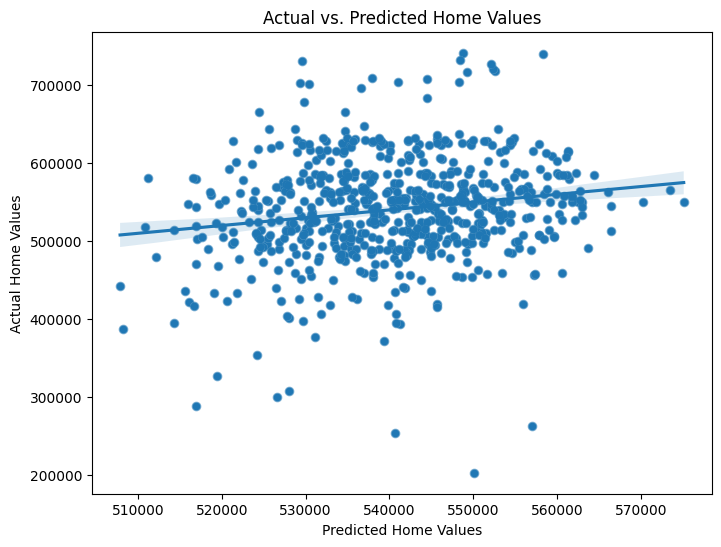

Average residuals -1.0218272762238792e-11
Average Positive residuals 48436.43644308478


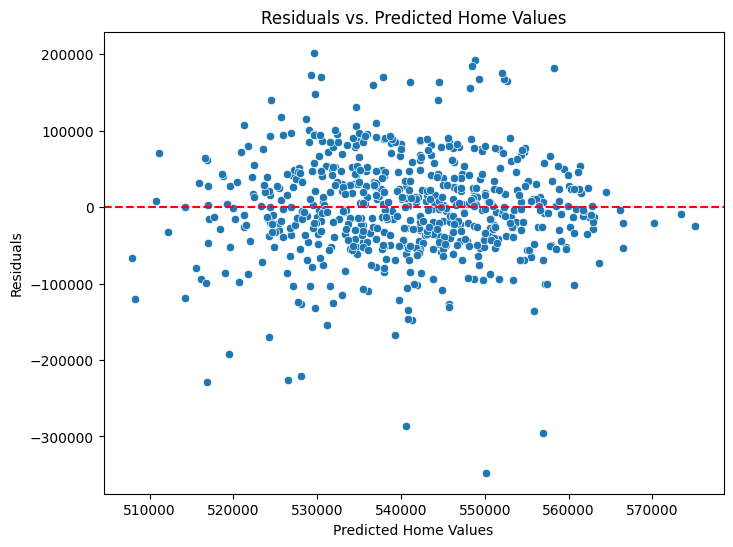

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


# Selecting features and target variable
X = merged_df[['year', 'wins', 'points_differential', 'strength_of_schedule', 'playoffs', 'sb_winner']]
y = merged_df['home']



# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Creating a multilinear regression model
multilinear_model = LinearRegression()

multilinear_model.fit(X_scaled, y)

# 10-fold cross-validation
mse_scores = cross_val_score(multilinear_model, X_scaled, y, scoring='neg_mean_squared_error', cv=10)
mse_scores = -mse_scores  # Convert negative MSE scores to positive

# Calculating mean and standard deviation
mean_mse = mse_scores.mean()
std_mse = mse_scores.std()

print(f'Mean Squared Error: {mean_mse}')
print(f'Standard Deviation of MSE: {std_mse}')
##r_squared = r2_score(y, y_pred)
##print(f'R-squared: {r_squared}')

# Get the predicted values
y_pred = multilinear_model.predict(X_scaled)


# Plot actual vs. predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=y)
sns.regplot(x=y_pred, y=y, scatter_kws={'alpha':0.5})
plt.xlabel('Predicted Home Values')
plt.ylabel('Actual Home Values')
plt.title('Actual vs. Predicted Home Values')
plt.show()

# Calculate residuals
residuals = y - y_pred
PosResiduals = abs(residuals)

print(f"Average residuals {residuals.mean()}")
print(f"Average Positive residuals {PosResiduals.mean()}")

# Plot residuals vs. predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.xlabel('Predicted Home Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Home Values')
plt.show()

The multilinear regressor performed poorly when tasked with this.

**Descision Tree Regressor**

Mean Squared Error: 8867542805.218973
Standard Deviation of MSE: 2388203123.226585
R-squared: 0.031011006862507018


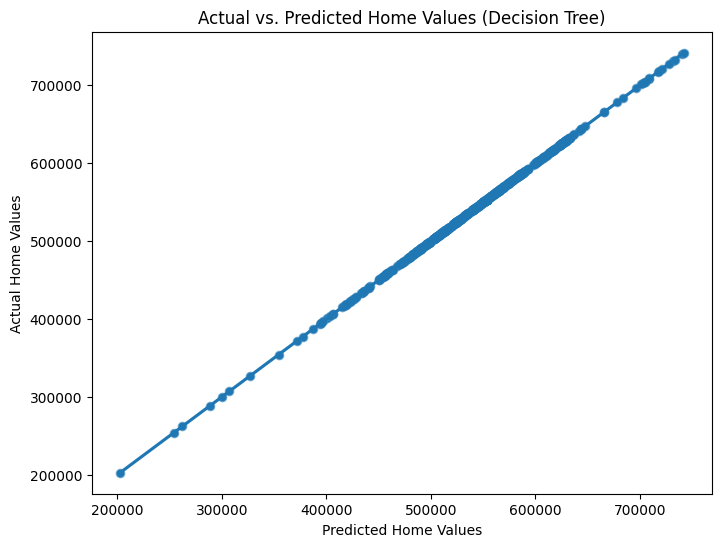

Average residuals 0.0
Average Positive residuals 0.0


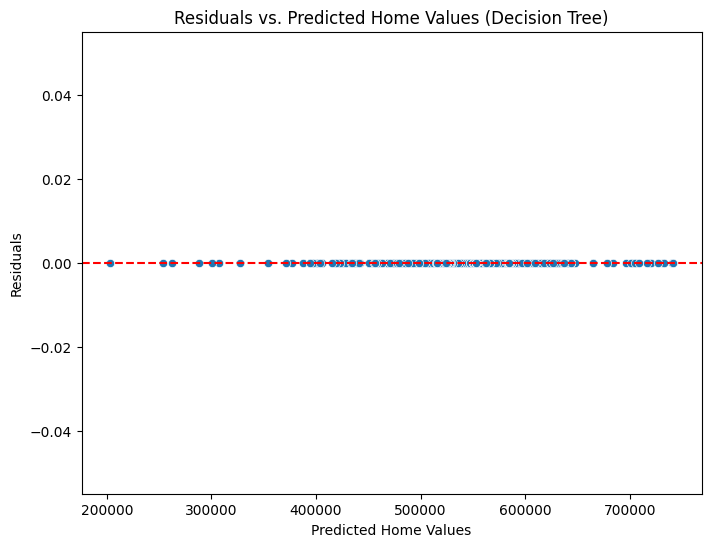

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error , r2_score
from sklearn.preprocessing import StandardScaler


# Selecting features and target variable
X = merged_df[['year', 'wins', 'points_differential', 'strength_of_schedule', 'sb_winner']]
y = merged_df['home']

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Creating a decision tree regressor model
tree_model = DecisionTreeRegressor(ccp_alpha=0, max_depth=None, min_samples_split=2,
                                   min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                                   max_features=None, random_state=None, max_leaf_nodes=None,
                                   min_impurity_decrease=0.0, splitter='best')

# Fit the model
tree_model.fit(X_scaled, y)

# Performing 10-fold cross-validation
mse_scores = cross_val_score(tree_model, X_scaled, y, scoring='neg_mean_squared_error', cv=10)
mse_scores = -mse_scores  # Convert negative MSE scores to positive

# Calculating mean and standard deviation of MSE scores
mean_mse = mse_scores.mean()
std_mse = mse_scores.std()

print(f'Mean Squared Error: {mean_mse}')
print(f'Standard Deviation of MSE: {std_mse}')
r_squared = r2_score(y, y_pred)
print(f'R-squared: {r_squared}')

# Get the predicted values
y_pred = tree_model.predict(X_scaled)

# Plot actual vs. predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=y)
sns.regplot(x=y_pred, y=y, scatter_kws={'alpha':0.5})
plt.xlabel('Predicted Home Values')
plt.ylabel('Actual Home Values')
plt.title('Actual vs. Predicted Home Values (Decision Tree)')
plt.show()


# Calculate residuals
residuals = y - y_pred
PosResiduals = abs(residuals)

print(f"Average residuals {residuals.mean()}")
print(f"Average Positive residuals {PosResiduals.mean()}")

# Plot residuals vs. predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.xlabel('Predicted Home Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Home Values (Decision Tree)')
plt.show()

Decision tree Regressor overfit data


**Random Forest Regressor**

Mean Squared Error: 3858156399.497336
R-squared: 0.012235690439854174


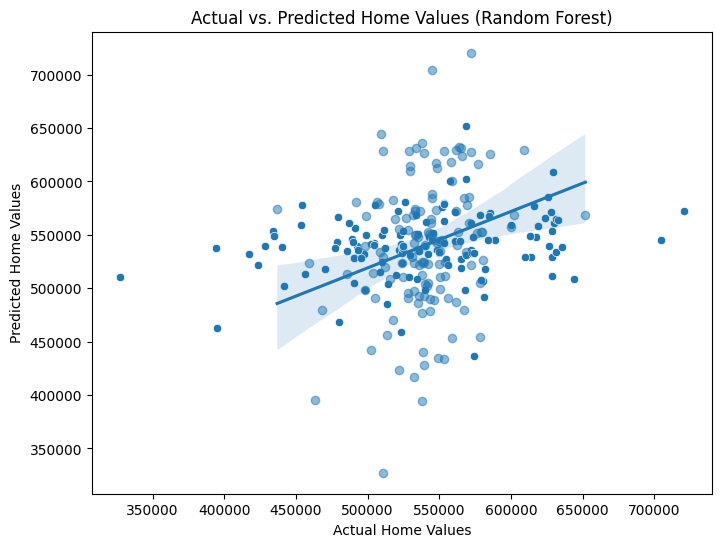

Average residuals 18.367734374995507
Average Positive residuals 48865.073515625


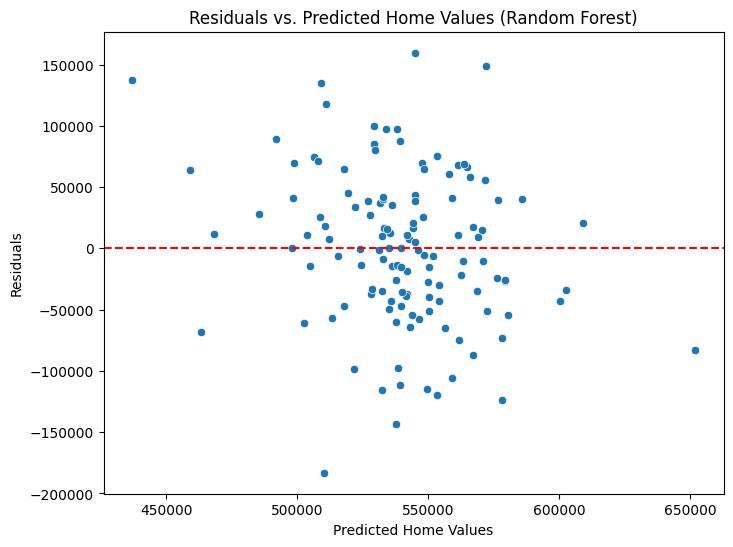

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


# Selecting features and target variable
X = merged_df[['year', 'wins', 'points_differential', 'strength_of_schedule', 'sb_winner']]
y = merged_df['home']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fitting the model
rf_model.fit(X_train, y_train)

# Predicting on the test set
y_pred = rf_model.predict(X_test)

# Calculating mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
r_squared = r2_score(y_test, y_pred)
print(f'R-squared: {r_squared}')

# Plotting actual vs. predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
sns.regplot(x=y_pred, y=y_test, scatter_kws={'alpha':0.5})
plt.xlabel('Actual Home Values')
plt.ylabel('Predicted Home Values')
plt.title('Actual vs. Predicted Home Values (Random Forest)')
plt.show()

# Calculate residuals
residuals = y_test - y_pred
PosResiduals = abs(residuals)

print(f"Average residuals {residuals.mean()}")
print(f"Average Positive residuals {PosResiduals.mean()}")

# Plot residuals vs. predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.xlabel('Predicted Home Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Home Values (Random Forest)')
plt.show()

**Changing Hyperparameters for decision tree**


The default values for a DecisionTreeRegressor in scikit-learn are as follows:

ccp_alpha=0.0

criterion='mse'

max_depth=None

max_features=None

max_leaf_nodes=None

min_impurity_decrease=0.0

min_impurity_split=None

min_samples_leaf=1

min_samples_split=2

min_weight_fraction_leaf=0.0

random_state=None

splitter='best'

Mean Squared Error: 8255631717.1117
Standard Deviation of MSE: 2145033245.2584698
R-squared: 0.9203227731174721


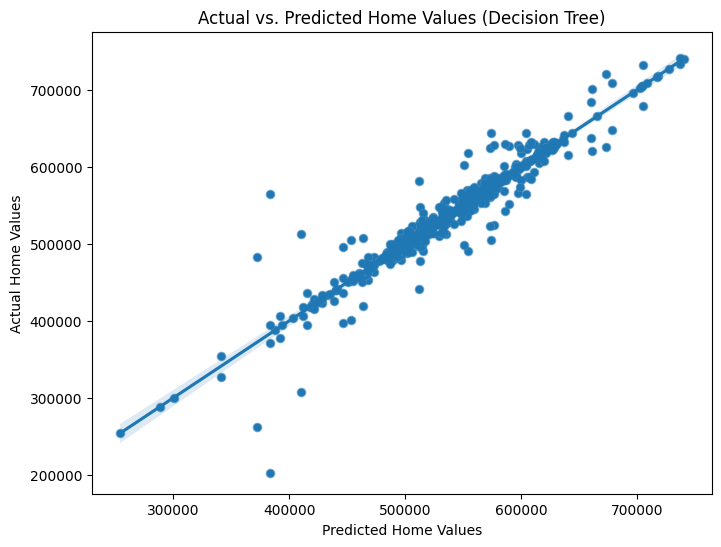

Average residuals 0.0
Average Positive residuals 8009.186520376175


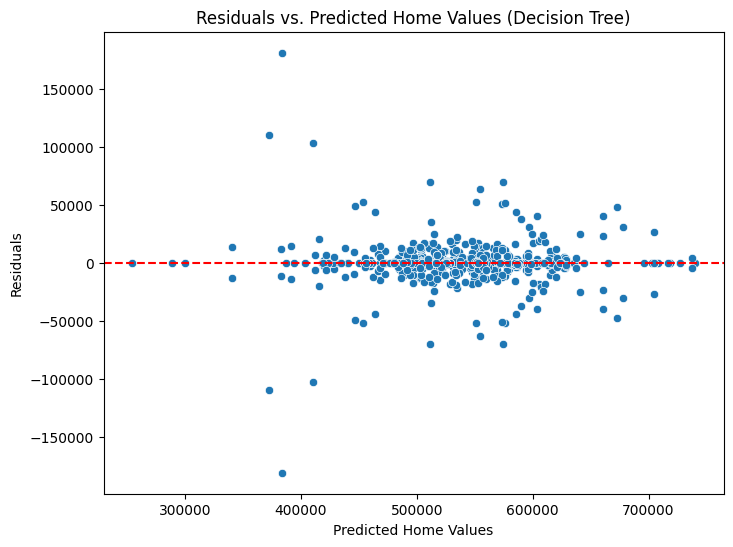

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


# Selecting features and target variable
X = merged_df[['year', 'wins', 'points_differential', 'strength_of_schedule', 'sb_winner']]
y = merged_df['home']

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Creating a decision tree regressor model
tree_model = DecisionTreeRegressor(ccp_alpha=0.0, max_depth=None, min_samples_split=3,
                                   min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                                   max_features=None, random_state= 42, max_leaf_nodes=None,
                                   min_impurity_decrease=0.0, splitter='best')

# Fit the model
tree_model.fit(X_scaled, y)

# Performing 10-fold cross-validation
mse_scores = cross_val_score(tree_model, X_scaled, y, scoring='neg_mean_squared_error', cv=10)
mse_scores = -mse_scores  # Convert negative MSE scores to positive

# Calculating mean and standard deviation of MSE scores
mean_mse = mse_scores.mean()
std_mse = mse_scores.std()

print(f'Mean Squared Error: {mean_mse}')
print(f'Standard Deviation of MSE: {std_mse}')


# Get the predicted values
y_pred = tree_model.predict(X_scaled)

r_squared = r2_score(y, y_pred)
print(f'R-squared: {r_squared}')

# Plot actual vs. predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=y)
sns.regplot(x=y_pred, y=y, scatter_kws={'alpha':0.5})
plt.xlabel('Predicted Home Values')
plt.ylabel('Actual Home Values')
plt.title('Actual vs. Predicted Home Values (Decision Tree)')
plt.show()


# Calculate residuals
residuals = y - y_pred
PosResiduals = abs(residuals)

print(f"Average residuals {residuals.mean()}")
print(f"Average Positive residuals {PosResiduals.mean()}")


# Plot residuals vs. predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.xlabel('Predicted Home Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Home Values (Decision Tree)')
plt.show()



Using the same HyperParamaters as last time but performing time-series. This creates a new model for every year. This is another validation method. As we can see the model performs much poorer under time-series validation. This should mean that the model is relying heavily on the year as a feature. This makes sense.

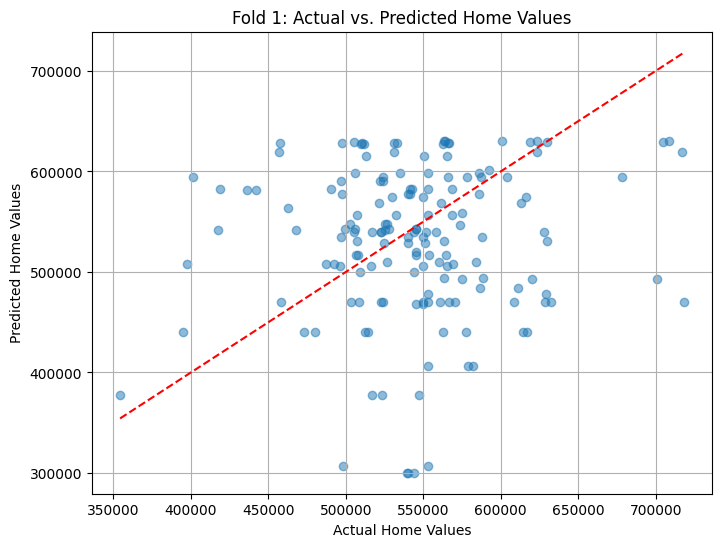

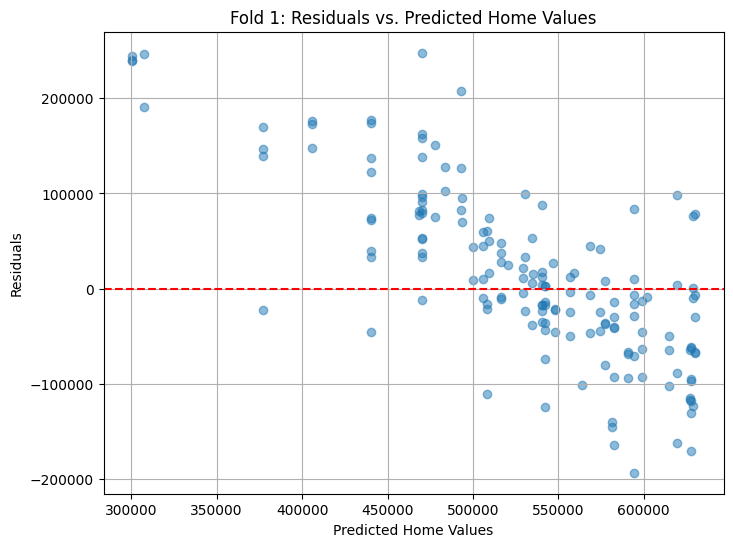

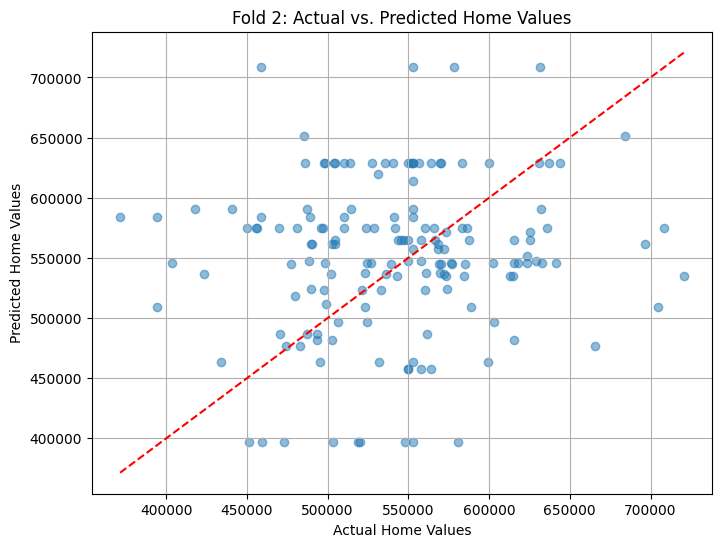

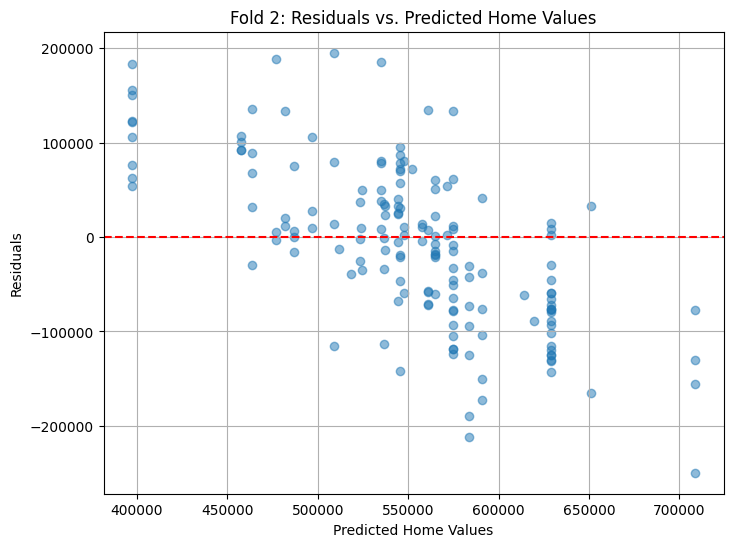

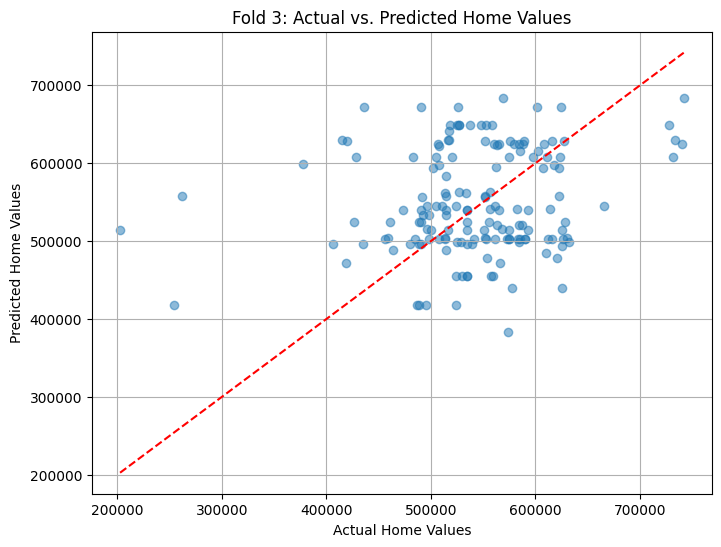

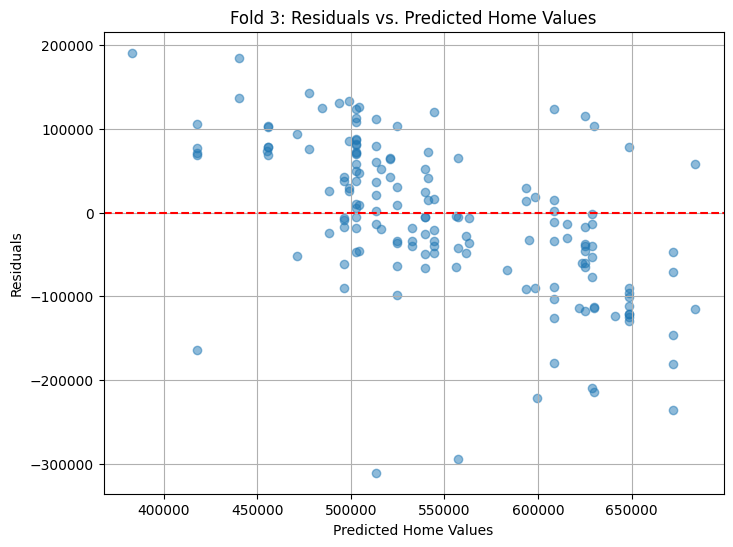

Average Mean Squared Error (Time Series Validation): 8062863135.607175
Average R-squared (Time Series Validation): -0.938109673283281


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assuming merged_df is your DataFrame sorted by 'year'
merged_df_sorted = merged_df.sort_values(by='year')

# Define the year intervals for time series validation
start_year = 2000
end_year = 2019
interval_years = 5
year_intervals = [(start, start + interval_years - 1) for start in range(start_year, end_year + 1, interval_years)]

# Initialize StandardScaler for feature scaling
scaler = StandardScaler()

# Initialize a Decision Tree Regressor model
tree_model = DecisionTreeRegressor(ccp_alpha=0.0, max_depth=None, min_samples_split=5,
                                   min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                                   max_features=None, random_state= 42, max_leaf_nodes=None,
                                   min_impurity_decrease=0.0, splitter='best')

# Initialize lists to store evaluation metrics
all_mse_scores = []
all_r_squared_scores = []

# Perform time series validation and evaluate the model
for fold_idx, (train_indices, test_indices) in enumerate(year_intervals):
    # Filter data based on the year interval
    train_mask = (merged_df_sorted['year'] >= train_indices) & (merged_df_sorted['year'] <= test_indices)
    test_mask = (merged_df_sorted['year'] >= test_indices + 1) & (merged_df_sorted['year'] <= test_indices + interval_years)

    X_train, y_train = merged_df_sorted[train_mask][['year', 'wins', 'points_differential', 'strength_of_schedule', 'sb_winner']], merged_df_sorted[train_mask]['home']
    X_test, y_test = merged_df_sorted[test_mask][['year', 'wins', 'points_differential', 'strength_of_schedule', 'sb_winner']], merged_df_sorted[test_mask]['home']

    if len(X_test) == 0:
        continue

    # Standardize features
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the model
    tree_model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred_test = tree_model.predict(X_test_scaled)

    # Evaluate the model
    mse_score = mean_squared_error(y_test, y_pred_test)
    r_squared_score = r2_score(y_test, y_pred_test)

    # Store evaluation scores
    all_mse_scores.append(mse_score)
    all_r_squared_scores.append(r_squared_score)

    # Plot predictions vs. actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred_test, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
    plt.xlabel('Actual Home Values')
    plt.ylabel('Predicted Home Values')
    plt.title(f'Fold {fold_idx+1}: Actual vs. Predicted Home Values')
    plt.grid(True)
    plt.show()

    # Calculate residuals
    residuals = y_test - y_pred_test

    # Plot residuals
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred_test, residuals, alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Predicted Home Values')
    plt.ylabel('Residuals')
    plt.title(f'Fold {fold_idx+1}: Residuals vs. Predicted Home Values')
    plt.grid(True)
    plt.show()

# Calculate average evaluation scores across all folds
avg_mse = np.mean(all_mse_scores)
avg_r_squared = np.mean(all_r_squared_scores)

print(f'Average Mean Squared Error (Time Series Validation): {avg_mse}')
print(f'Average R-squared (Time Series Validation): {avg_r_squared}')

**This model seems to work poorly over time and or handle the change in distributions over time**


**[Second attempt at multilinear regression using, feature selection]**

Mean Squared Error: 4564917437.641882
Standard Deviation of MSE: 2107079926.243518
R-squared: 0.028446900015092424
Average residuals -4.762444983829152e-11
Average Positive residuals 48532.08282025012


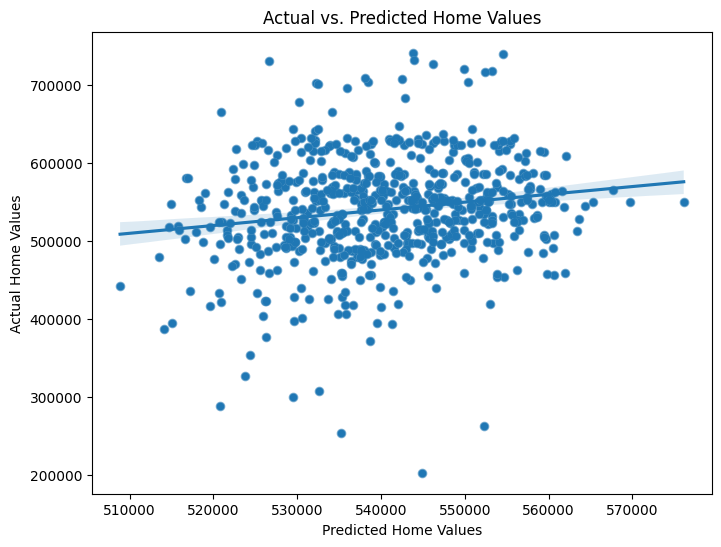

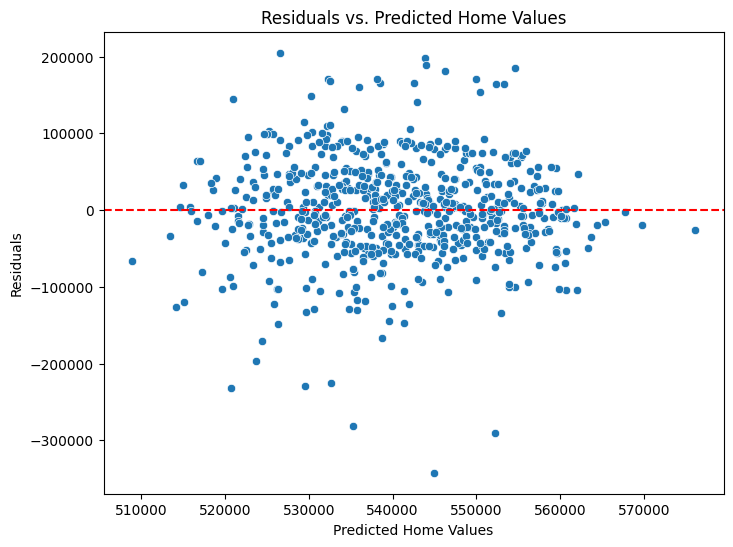

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
import matplotlib.pyplot as plt
import seaborn as sns

# Selecting features and target variable
X = merged_df[['year', 'wins', 'points_differential', 'strength_of_schedule', 'sb_winner', 'simple_rating']]
y = merged_df['home']

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Feature selection using SelectKBest with f_regression scoring
select_k_best = SelectKBest(score_func=f_regression, k=3)  # Select top 3 features
X_selected = select_k_best.fit_transform(X_scaled, y)

# Creating a multilinear regression model
multilinear_model = LinearRegression()

# Fit the model using selected features
multilinear_model.fit(X_selected, y)

# 10-fold cross-validation
mse_scores = cross_val_score(multilinear_model, X_selected, y, scoring='neg_mean_squared_error', cv=10)
mse_scores = -mse_scores  # Convert negative MSE scores to positive

# Calculating mean and standard deviation
mean_mse = mse_scores.mean()
std_mse = mse_scores.std()

print(f'Mean Squared Error: {mean_mse}')
print(f'Standard Deviation of MSE: {std_mse}')

# Get the predicted values
y_pred = multilinear_model.predict(X_selected)

r_squared = r2_score(y, y_pred)
print(f'R-squared: {r_squared}')

# Calculate residuals
residuals = y - y_pred
PosResiduals = abs(residuals)

print(f"Average residuals {residuals.mean()}")
print(f"Average Positive residuals {PosResiduals.mean()}")

# Plot actual vs. predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=y)
sns.regplot(x=y_pred, y=y, scatter_kws={'alpha':0.5})
plt.xlabel('Predicted Home Values')
plt.ylabel('Actual Home Values')
plt.title('Actual vs. Predicted Home Values')
plt.show()

# Plot residuals vs. predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.xlabel('Predicted Home Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Home Values')
plt.show()

Nothing works. the data doesnt correlate for yearly attendance. It seems as if a teams yearly attendance is very consistent or that Team performance/schedule doesn't seem to have any effect.


Second Attempt for **Random Forest** with different hyperparameters
default

n_estimators: 100

max_depth: None (unlimited)

min_samples_split: 2

min_samples_leaf: 1


added 'simple_rating' and 'margin_of_victory' feature removed sb_winner



Mean Squared Error: 3389028664.4715257
R-squared: 0.13234166471908693


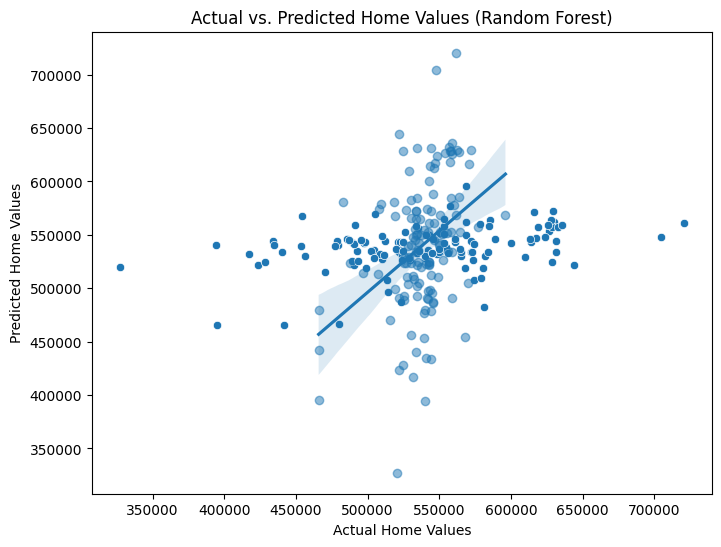

Average residuals 2033.0593196795726
Average Positive residuals 44885.898850108424


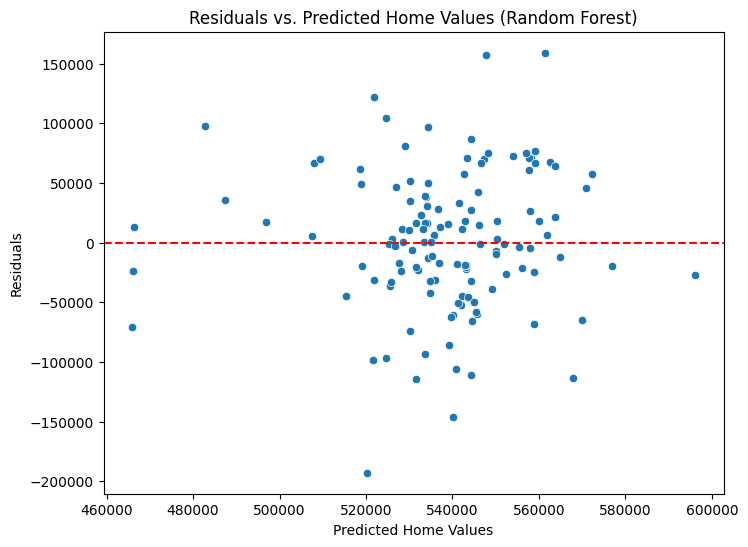

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns



# Selecting features and target variable
X = merged_df[['year', 'wins', 'points_differential', 'strength_of_schedule', 'simple_rating','margin_of_victory']]
y = merged_df['home']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=350,  # Increase number of trees
                                  max_depth=None,  # Limit maximum depth of each tree
                                  min_samples_split=25,  # Increase minimum samples required to split
                                  min_samples_leaf=2,  # Increase minimum samples required at leaf nodes
                                  max_features='sqrt',  # Use square root of features for each split
                                  random_state=42)

# Fitting the model
rf_model.fit(X_train, y_train)

# Predicting on the test set
y_pred = rf_model.predict(X_test)

# Calculating mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
r_squared = r2_score(y_test, y_pred)
print(f'R-squared: {r_squared}')

# Plotting actual vs. predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
sns.regplot(x=y_pred, y=y_test, scatter_kws={'alpha':0.5})
plt.xlabel('Actual Home Values')
plt.ylabel('Predicted Home Values')
plt.title('Actual vs. Predicted Home Values (Random Forest)')
plt.show()

# Calculate residuals
residuals = y_test - y_pred
PosResiduals = abs(residuals)

print(f"Average residuals {residuals.mean()}")
print(f"Average Positive residuals {PosResiduals.mean()}")

# Plot residuals vs. predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.xlabel('Predicted Home Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Home Values (Random Forest)')
plt.show()

Conclusions:
- In continuing this project I would like to add some economic data to the dataset. even something as simple as the CPI (Consumer Price Index). To see if there can be any "general trend found. Also looking at average ticket prices may help Then I could use some of these more detached features to make these predictions more accurate.
- Some sort of feature engineering could be added in order to alleviate some of these issues. An idea would be maybe to give every team a $/point value in order to find some sort of trend.


- Best performance came from using a descision tree regressor and generalizing it as it had overfit data. To do this:
  -I changed the hyper parameters to generalize the model
  - The model still performed poorly, but only under time-series validation.
    -This could mean that the model does not generalize well over the years, but instead is using the year as a key feature.